In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt
tf.random.set_seed(123)
np.random.seed(123)

In [3]:
df = pd.read_csv('/Users/AL MADINA COMPUTER/Desktop/Metro_Interstate_Traffic_Volume.csv')

In [4]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [5]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


In [6]:
df.drop_duplicates(subset=['date_time'], keep=False,inplace=True)

In [7]:
holiday_le = preprocessing.LabelEncoder()
df['holiday_le'] = holiday_le.fit_transform(df['holiday']) 
weather_main_le = preprocessing.LabelEncoder()
df['weather_main_le'] = weather_main_le.fit_transform(df['weather_main']) 
weather_description_le = preprocessing.LabelEncoder()
df['weather_description_le'] = weather_description_le.fit_transform(df['weather_description']) 

<AxesSubplot:>

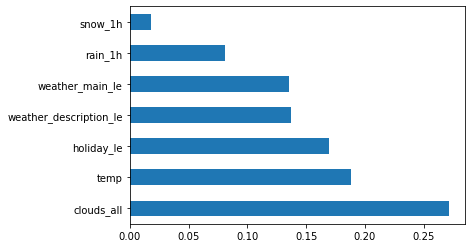

In [8]:
from numpy import loadtxt
from xgboost import XGBRegressor
from matplotlib import pyplot

model = XGBRegressor()
model.fit(df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le']],df[['traffic_volume']])

(pd.Series(model.feature_importances_, index=df[['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le']].columns)
   .nlargest(7)
   .plot(kind='barh'))

In [9]:
df = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']]

In [10]:
def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon

    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])

        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y)

In [11]:
validate = df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']].tail(10)
df.drop(df.tail(10).index,inplace=True)

In [12]:
x_scaler = preprocessing.MinMaxScaler()
y_scaler = preprocessing.MinMaxScaler()
dataX = x_scaler.fit_transform(df[['rain_1h','temp', 'snow_1h', 'clouds_all', 'holiday_le',
    'weather_main_le', 'weather_description_le','traffic_volume']])
dataY = y_scaler.fit_transform(df[['traffic_volume']])

In [13]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 30000
x_train_multi, y_train_multi = custom_ts_multi_data_prep(
    dataX, dataY, 0, TRAIN_SPLIT, hist_window, horizon)
x_val_multi, y_val_multi= custom_ts_multi_data_prep(
    dataX, dataY, TRAIN_SPLIT, None, hist_window, horizon)

In [14]:
print ('Single window of past history')
print(x_train_multi[0])
print ('\n Target horizon')
print (y_train_multi[0])

Single window of past history
[[0.         0.92972555 0.         0.4        0.63636364 0.1
  0.7        0.76167582]
 [0.         0.93320863 0.         0.75       0.63636364 0.1
  0.06666667 0.62032967]
 [0.         0.93391815 0.         0.9        0.63636364 0.1
  0.56666667 0.65480769]
 [0.         0.93569194 0.         0.9        0.63636364 0.1
  0.56666667 0.69038462]
 [0.         0.93894927 0.         0.75       0.63636364 0.1
  0.06666667 0.67554945]
 [0.         0.94081981 0.         0.01       0.63636364 0.
  0.73333333 0.71167582]
 [0.         0.94549618 0.         0.01       0.63636364 0.
  0.73333333 0.76703297]
 [0.         0.94772148 0.         0.01       0.63636364 0.
  0.73333333 0.82623626]
 [0.         0.9486245  0.         0.2        0.63636364 0.1
  0.13333333 0.79546703]
 [0.         0.94527042 0.         0.2        0.63636364 0.1
  0.13333333 0.65521978]
 [0.         0.93840101 0.         0.2        0.63636364 0.1
  0.13333333 0.48612637]
 [0.         0.93327313 0. 

In [15]:
BATCH_SIZE = 256
BUFFER_SIZE = 150

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

In [16]:
lstm_multi = tf.keras.models.Sequential()
lstm_multi.add(tf.keras.layers.LSTM(150,input_shape=x_train_multi.shape[-2:],return_sequences=True))
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.LSTM(units=100,return_sequences=False)),
lstm_multi.add(tf.keras.layers.Dropout(0.2)),
lstm_multi.add(tf.keras.layers.Dense(units=horizon)),
lstm_multi.compile(optimizer='adam', loss='mse')

In [17]:
model_path = r'\Chapter 7\LSTM_Multivariate.h5'

In [18]:
EVALUATION_INTERVAL = 150
EPOCHS = 100
history = lstm_multi.fit(train_data_multi, epochs=EPOCHS,steps_per_epoch=EVALUATION_INTERVAL,validation_data=val_data_multi, validation_steps=50,verbose =1,
                              callbacks =[tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min'),tf.keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)])

Epoch 1/100
150/150 [==============================] - ETA: 0s - loss: 0.0720

NotFoundError: Failed to create a directory: \/Chapter 7; No such file or directory